# **Audio Signal Analysis and Speech Recognition - project**
### by: **Kamil Jaworski**

### topic: Keyword spotting from the limited dictionary. The system should be able to detect a small number of keywords spoken by different people (even with background noise or in continuous speech). Something like "ok google" or "hey siri"

Keyword detection systems serve an increasingly crucial role in user interaction with technology through voice commands. 

These systems, which are integral to virtual assistants, voice-controlled applications, and accessibility tools, need to accurately recognize specific words or phrases.

The project was conducted in following stages:

#### Google Speech Commands Data Set

For this project we decided to use Google's Speech Commands Data Set v0.02. This is a set of one-second `.wav` audio files, each containing a single spoken English word.

These words are from a small set of commands, and are spoken by a variety of different speakers. The audio files are organized into folders based on the word they contain,and this data set is designed to help train simple machine learning models. 
 
 To distribute the files into `Training`, `Validation`, and `Testing` categories, a customized pre-coded hash function was utilized for simple sorting. 

Users have the flexibility to specify the distribution percentages for Validation and Testing data. The remaining portion is automatically allocated for the Training phase.

Dataset is availabe here: http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

This dataset is covered in more detail at https://arxiv.org/abs/1804.03209

In [1]:
import os
import re
import hashlib
import shutil
import random

MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

def which_set_and_copy(filename, validation_percentage, testing_percentage, data_dir, words):
    base_name = os.path.basename(filename)
    hash_name = re.sub(r'_nohash_.*$', '', base_name)
    hash_name_hashed = hashlib.sha1(hash_name.encode()).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))

    if percentage_hash < validation_percentage:
        set_dir = os.path.join(data_dir, 'validation')
    elif percentage_hash < (testing_percentage + validation_percentage):
        set_dir = os.path.join(data_dir, 'testing')
    else:
        set_dir = os.path.join(data_dir, 'training')

    word_subdir = os.path.basename(os.path.dirname(filename))
    set_word_dir = os.path.join(set_dir, word_subdir)

    # creates the set and word directories if they don't exist
    os.makedirs(set_dir, exist_ok=True)
    os.makedirs(set_word_dir, exist_ok=True)

    # copies the file to the appropriate set and word directory
    dest_file = os.path.join(set_word_dir, base_name)
    shutil.copy2(filename, dest_file)

def copy_files_to_sets(original_directory, data_directory, validation_percentage, testing_percentage):

    # gets the list of words in subdirectories in the original directory
    words = [word for word in os.listdir(original_directory) if os.path.isdir(os.path.join(original_directory, word))]

    # iterates through all files in the original directory and copy them
    for word in words:
        word_directory = os.path.join(original_directory, word)
        for root, _, files in os.walk(word_directory):
            for file in files:
                if file.endswith(".wav"):
                    file_path = os.path.join(root, file)
                    which_set_and_copy(file_path, validation_percentage, testing_percentage, data_directory, words)

# providing paths and percentage
original_data_directory = 'C:/Users/kamil/OneDrive/Pulpit/easar dataset/speech_commands_v0.02'
data_directory = 'C:/Users/kamil/OneDrive/Pulpit/Nowy EASAR1'

# choose 
validation_percentage = 20  # Adjust as neededed
testing_percentage = 10  # Adjust as neededed

copy_files_to_sets(original_data_directory, data_directory, validation_percentage, testing_percentage)


### Importing libraries

Importing necessary libraries like: `numpy`, `tensorflor`, `keras`, `librosa` and other:

In [1]:
%pip install tensorflow librosa soundfile keras seaborn

import tensorflow as tf
import numpy as np
import os
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

Note: you may need to restart the kernel to use updated packages.



### Defining paths to .wav files for `Trainig`, `Validation` and `Testing`
- keywords:
  - `down`
  - `yes`
  - `zero`
- non-keywords used for training:
 
 `backward`, `bed`, `bird`, `cat`, `dog`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`

In [3]:
# creates a list of paths for each category
def create_paths(base_path, categories):
    paths = []
    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            paths.append(category_path)
        else:
            print(f"Warning: Directory {category_path} does not exist.")
    return paths

# base paths
base_training_keywords_path = r"C:\Users\kamil\OneDrive\Pulpit\PW\sem1\EASARdataset1\TrainingKeyWords"
base_training_non_keywords_path = r"C:\Users\kamil\OneDrive\Pulpit\PW\sem1\EASARdataset1\TrainingNonKeyWords"

base_validation_keywords_path = r"C:\Users\kamil\OneDrive\Pulpit\PW\sem1\EASARdataset1\ValidationKeyWords"
base_validation_non_keywords_path = r"C:\Users\kamil\OneDrive\Pulpit\PW\sem1\EASARdataset1\ValidationNonKeyWords"

base_testing_keywords_path = r"C:\Users\kamil\OneDrive\Pulpit\PW\sem1\EASARdataset1\TestingKeyWords"
base_testing_non_keywords_path = r"C:\Users\kamil\OneDrive\Pulpit\PW\sem1\EASARdataset1\TestingNonKeyWords"


# finding categories in each base path
training_keyword_categories = os.listdir(base_training_keywords_path)
training_non_keyword_categories = os.listdir(base_training_non_keywords_path)
validation_keyword_categories = os.listdir(base_validation_keywords_path)
validation_non_keyword_categories = os.listdir(base_validation_non_keywords_path)
testing_keyword_categories = os.listdir(base_testing_keywords_path)
testing_non_keyword_categories = os.listdir(base_testing_non_keywords_path)

# creating paths
keyword_paths = create_paths(base_training_keywords_path, training_keyword_categories)
non_keyword_paths = create_paths(base_training_non_keywords_path, training_non_keyword_categories)
validation_keyword_paths = create_paths(base_validation_keywords_path, validation_keyword_categories)
validation_non_keyword_paths = create_paths(base_validation_non_keywords_path, validation_non_keyword_categories)
testing_keyword_paths = create_paths(base_testing_keywords_path, testing_keyword_categories)
testing_non_keyword_paths = create_paths(base_testing_non_keywords_path, testing_non_keyword_categories)

# printing paths to verify if everything is correct
print("Keyword Paths:", keyword_paths)
print("Non-Keyword Paths:", non_keyword_paths)
print("Validation Keyword Paths:", validation_keyword_paths)
print("Validation Non-Keyword Paths:", validation_non_keyword_paths)
print("testing Keyword Paths:", testing_keyword_paths)
print("testing Non-Keyword Paths:", testing_non_keyword_paths)

Keyword Paths: ['C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingKeyWords\\down', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingKeyWords\\yes', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingKeyWords\\zero']
Non-Keyword Paths: ['C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingNonKeyWords\\backward', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingNonKeyWords\\bed', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingNonKeyWords\\bird', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingNonKeyWords\\cat', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingNonKeyWords\\dog', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingNonKeyWords\\eight', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingNonKeyWords\\five', 'C:\\Users\\kamil\\OneDrive\\Pulpit\\PW\\sem1\\EASARdataset1\\TrainingNo

### Mel-Frequency Cepstral Coefficients (MFCCs)

This segment focuses on extracting Mel-Frequency Cepstral Coefficients (MFCCs) and their derivatives (Delta and Delta-Delta), owing to their proven efficacy in capturing essential attributes of the audio signal.

`MFCCs` transforms the audio from the `time domain` into the `cepstral domain`, because that way it is easier to analyze. This transformation reduces the complexity of the audio signal while retaining important information.

`The first-order derivatives of MFCCs` also known as `Delta features`, provide information about the rate of change of the spectral features. They capture the dynamic aspects of the speech, such as speed and intonation, which are important for understanding the natural flow and rhythm of speech.

`The second-order derivatives`, also known as `Delta-Delta features` offer information about the acceleration or deceleration of the spectral features. They add another layer of contextual information, capturing how quickly the speech dynamics (like pitch and tone) are changing.

These features were combined using `np.dstack()` function. 


These are audio processing parameters which could be adjusted:

`max_length`: Maximum length of the audio in samples. If the audio is shorter than this length, it will be padded with zeros.

`num_mfcc`:  Number of MFCC features to extract.

`n_fft`: The number of data points used in each block for the FFT (Fast Fourier Transform) during MFCC calculation.

`hop_length`: The number of samples between successive frames - MFCC frames.

In [4]:
def load_audio_files(path, max_length=None, num_mfcc=20, n_fft=2048, hop_length=512):
    audio_data = []  # List to store all audio data

    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):                 # Processing only .wav files (just in case)
                file_path = os.path.join(root, file)
                audio, _ = sf.read(file_path)         # Reading audio file

                if max_length and len(audio) < max_length:    # If max_length is set and the audio is shorter, pad it with zeros
                    padding = max_length - len(audio)
                    audio = np.pad(audio, (0, padding), mode = 'constant')

                mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length) # Extracting MFCC features from the audio
                delta_mfcc = librosa.feature.delta(mfcc)                                                            # Computing the first-order derivatives of MFCC
                delta2_mfcc = librosa.feature.delta(mfcc, order=2)                                                  # Computing the second-order derivatives of MFCC

                combined_mfcc = np.dstack((mfcc, delta_mfcc, delta2_mfcc))   # Combining and appending features to the audio_data list
                audio_data.append(combined_mfcc)

                #print(f"Loaded and processed: {file_path}")

    return np.array(audio_data)

# audio processing parameters
max_audio_length = 16000  # Adjusting audio file's sample rate
num_mfcc = 20             # Increasing number of MFCC coefficients
n_fft = 2048              # FFT window size
hop_length = 512          # Hop length

# loads and processes all audio files in given paths
def process_audio_data(paths):
    return np.concatenate([load_audio_files(path, max_length=max_audio_length, num_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length) for path in paths])

# processing the audio files
keyword_mfcc = process_audio_data(keyword_paths)
non_keyword_mfcc = process_audio_data(non_keyword_paths)

validation_keyword_mfcc = process_audio_data(validation_keyword_paths)
validation_non_keyword_mfcc = process_audio_data(validation_non_keyword_paths)

testing_keyword_mfcc = process_audio_data(testing_keyword_paths)
testing_non_keyword_mfcc = process_audio_data(testing_non_keyword_paths)

### MFCC testing for one .wav file
This section involves the extraction of Mel-Frequency Cepstral Coefficients (MFCCs) along with their derivatives (Delta and Delta-Delta) from a file. The extracted values are then displayed and plotted for visual analysis.

MFCC Values:
[[-5.69664000e+02 -5.55033831e+02 -4.22424675e+02 -2.07347636e+02
  -1.17000267e+02 -8.97657066e+01 -8.86159777e+01 -8.69740018e+01
  -9.30387599e+01 -1.14539609e+02 -1.49249304e+02 -1.94949177e+02
  -2.36114335e+02 -2.75880343e+02 -3.10205938e+02 -3.56965813e+02
  -3.99064855e+02 -4.33523782e+02 -4.61264432e+02 -4.89182208e+02
  -5.19444976e+02 -5.32456943e+02 -5.51138230e+02 -5.75817834e+02
  -5.89151132e+02 -5.89522494e+02 -6.03205747e+02 -6.20250106e+02
  -6.20759720e+02 -6.21319524e+02 -6.23745279e+02 -6.30874390e+02]
 [-8.37750397e+01 -9.57756278e+01 -1.05853587e+01  7.73770497e+01
   1.03235927e+02  1.18984685e+02  1.22261219e+02  1.26957525e+02
   1.32650376e+02  1.43213731e+02  1.55743981e+02  1.56460491e+02
   1.59193589e+02  1.64484238e+02  1.67301454e+02  1.76105774e+02
   1.68937707e+02  1.46955632e+02  1.35878607e+02  1.21784486e+02
   9.97768263e+01  9.12742230e+01  8.49394462e+01  7.32009864e+01
   6.72063403e+01  7.01501506e+01  5.83326380e+01  4.52029274e

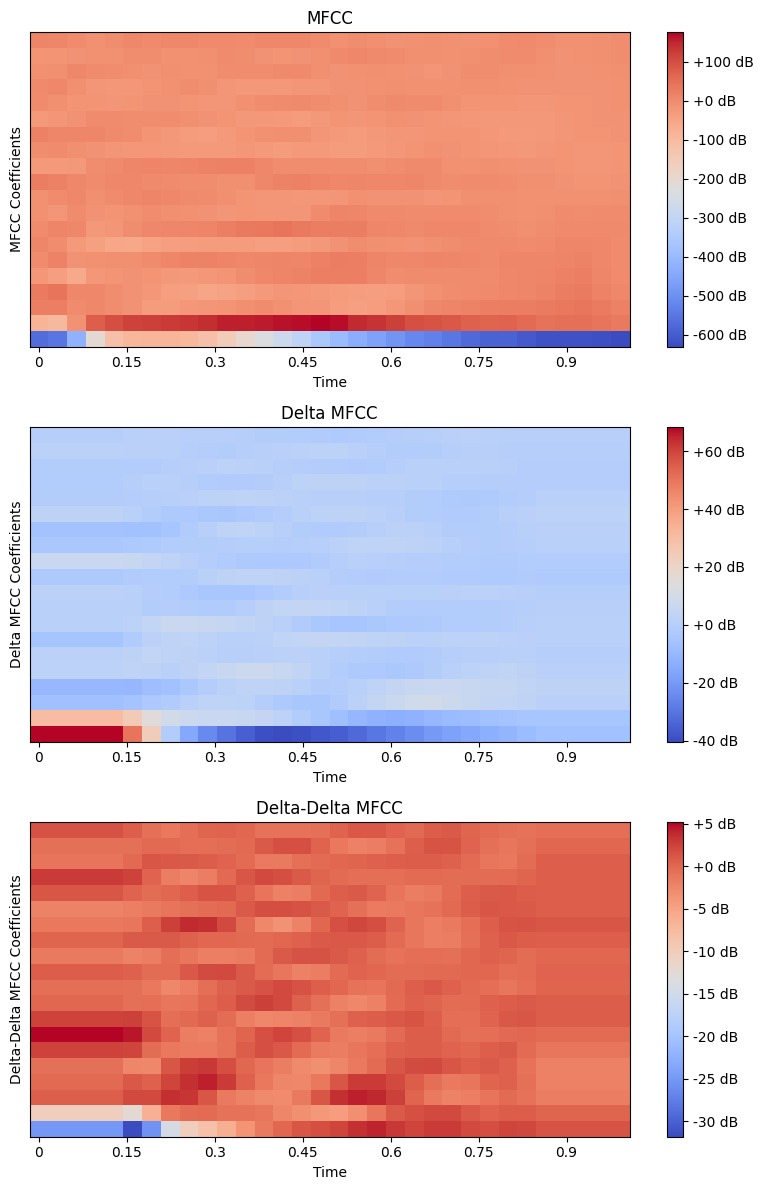

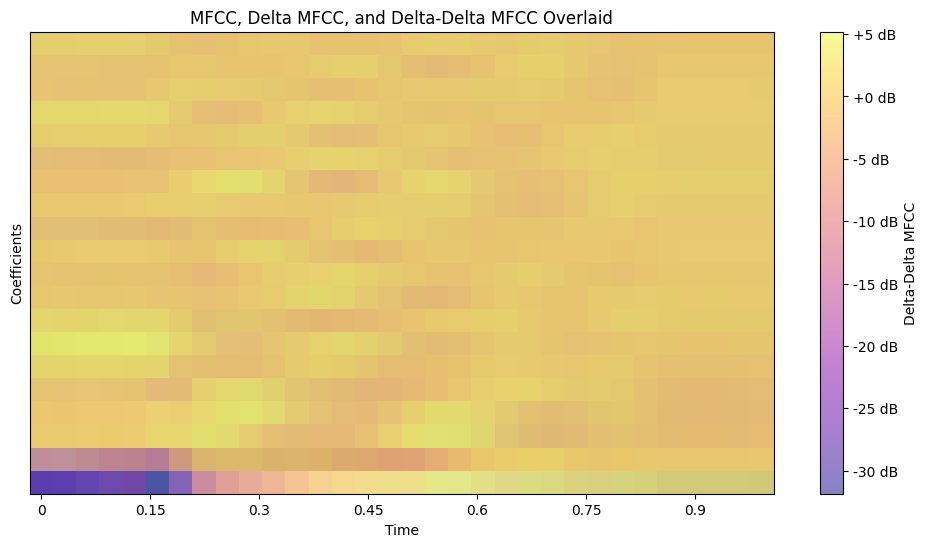


Shape of MFCC matrix: (20, 32)
Shape of first-order derivatives of MFCC matrix: (20, 32)
Shape of second-order derivatives of MFCC matrix: (20, 32)
Shape of combined MFCC and both deltas matrices: (20, 32, 3)


In [ ]:
example_audio_path = r"C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\audiofiles\0cb74144_nohash_3.wav"

# loading audio file
example_audio, sr = sf.read(example_audio_path)

# parameters for MFCC computation
num_mfcc = 20
n_fft = 2048
hop_length = 512
max_audio_length = 16000  # Adjust as needed

# padding the audio file if it's shorter than the maximum length
if len(example_audio) < max_audio_length:
    padding = max_audio_length - len(example_audio)
    example_audio = np.pad(example_audio, (0, padding), mode='constant')

# extracting MFCC features
example_mfcc = librosa.feature.mfcc(y=example_audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

# extracting Delta and Delta-Delta features
delta_mfcc = librosa.feature.delta(example_mfcc)
delta2_mfcc = librosa.feature.delta(example_mfcc, order=2)
combined_mfcc = np.dstack((example_mfcc, delta_mfcc, delta2_mfcc))
concatenated_features = np.concatenate((example_mfcc, delta_mfcc, delta2_mfcc), axis=1)

# prints the MFCC values
print("MFCC Values:")
print(example_mfcc)
plt.figure(figsize=(8, 12))

# plots MFCC features
plt.subplot(3, 1, 1)
librosa.display.specshow(example_mfcc, sr=sr, hop_length=hop_length, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')

# plots Delta MFCC
plt.subplot(3, 1, 2)
librosa.display.specshow(delta_mfcc, sr=sr, hop_length=hop_length, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Delta MFCC')
plt.xlabel('Time')
plt.ylabel('Delta MFCC Coefficients')

# plots Delta-Delta MFCC
plt.subplot(3, 1, 3)
librosa.display.specshow(delta2_mfcc, sr=sr, hop_length=hop_length, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Delta-Delta MFCC')
plt.xlabel('Time')
plt.ylabel('Delta-Delta MFCC Coefficients')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Plot MFCC
librosa.display.specshow(example_mfcc, sr=sr, hop_length=hop_length, x_axis='time', alpha=0.5, cmap='coolwarm')

# Overlay Delta MFCC
librosa.display.specshow(delta_mfcc, sr=sr, hop_length=hop_length, x_axis='time', alpha=0.5, cmap='GnBu')

# Overlay Delta-Delta MFCC
librosa.display.specshow(delta2_mfcc, sr=sr, hop_length=hop_length, x_axis='time', alpha=0.5, cmap='plasma')
plt.colorbar(format='%+2.0f dB', label='Delta-Delta MFCC')

plt.title('MFCC, Delta MFCC, and Delta-Delta MFCC Overlaid')
plt.xlabel('Time')
plt.ylabel('Coefficients')
plt.show()

print("\nShape of MFCC matrix:", example_mfcc.shape)
print("Shape of first-order derivatives of MFCC matrix:", delta_mfcc.shape)
print("Shape of second-order derivatives of MFCC matrix:", delta2_mfcc.shape)
print("Shape of combined MFCC and both deltas matrices:", combined_mfcc.shape)
Audio(example_audio_path)


### Preprocessing data for training

This code segment is designed for the preprocessing and labeling of audio data for machine learning purposes for keyword detection. It involves data partitioning, file counting, and label encoding.



In [161]:
X_train = np.concatenate((keyword_mfcc, non_keyword_mfcc))[..., np.newaxis]
X_validation = np.concatenate((validation_keyword_mfcc, validation_non_keyword_mfcc))[..., np.newaxis]
X_test = np.concatenate((testing_keyword_mfcc, testing_non_keyword_mfcc))[..., np.newaxis]

# Function to dynamically count files in each category
def count_files(paths):
    return [len(os.listdir(path)) for path in paths]

# Count the number of files in each keyword and non-keyword category
train_keyword_file_counts = count_files(keyword_paths)
train_non_keyword_file_counts = count_files(non_keyword_paths)
validation_keyword_file_counts = count_files(validation_keyword_paths)
validation_non_keyword_file_counts = count_files(validation_non_keyword_paths)
testing_keyword_file_counts = count_files(testing_keyword_paths)
testing_non_keyword_file_counts = count_files(testing_non_keyword_paths)

# Creating labels for each category
num_keywords = len(keyword_paths)
num_non_keywords = len(non_keyword_paths)

# training labels
y_train = []
for i in range(num_keywords):
    y_train += [i] * train_keyword_file_counts[i]
y_train += [num_keywords] * sum(train_non_keyword_file_counts)  # label for all non-keywords

# validation labels
y_validation = []
for i in range(num_keywords):
    y_validation += [i] * validation_keyword_file_counts[i]
y_validation += [num_keywords] * sum(validation_non_keyword_file_counts)  # label for all non-keywords

# testing labels
y_test = []
for i in range(num_keywords):
    y_test += [i] * testing_keyword_file_counts[i]
y_test += [num_keywords] * sum(testing_non_keyword_file_counts)  # label for all non-keywords

# converts lists to arrays
y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

# one-hot encoding of labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_keywords + 1)
y_validation = tf.keras.utils.to_categorical(y_validation, num_classes=num_keywords + 1)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_keywords + 1)

# Print the shapes to verify is the values match eachother
print("X_train shape:     ", X_train.shape,      "y_train shape:     ", y_train.shape)
print("X_validation shape:", X_validation.shape, "y_validation shape:", y_validation.shape)
print("X_test shape:      ", X_test.shape,       " y_test shape:      ", y_test.shape)


X_train shape:      (75466, 20, 32, 3, 1) y_train shape:      (75466, 4)
X_validation shape: (20986, 20, 32, 3, 1) y_validation shape: (20986, 4)
X_test shape:       (9377, 20, 32, 3, 1)  y_test shape:       (9377, 4)


### Building a Convolutional Neural Network (CNN) model

For keyword detection task a `Sequential` model from Keras is used, allowing for the linear stacking of layers.

**Key Points of the Model**:

- **Convolutional Layers**:

   The model consists of `four` convolutional layers, each followed by `batch normalization` and `max pooling`. The number of filters in these layers increases (32, 64, 128, 256), allowing the model to capture complex features.

- **Batch Normalization**:
  
  This is used after each convolutional layer to improve training stability and performance.

- **Max Pooling Layers**:

  These layers reduce the spatial dimensions of the output from the convolutional layers, which helps to reduce the computational load and the number of parameters.

- **Global Average Pooling**:
  
  This layer simplifies the output from the convolutional layers by averaging the values, reducing the total number of parameters and helping to prevent overfitting.

- **Dense Layers**:

  These two fully connected dense layers increase the model's learning capacity.
  
- **Dropout Layers**:  
  
  Dropout layers are added after each dense layer to reduce overfitting by randomly setting a fraction of the neurons to zero during training.

- **L2 Regularization**

  L2 regularization is a technique used to reduce overfitting by penalizing large weights in the model's learning process.

- **Exponential Decay**

  The ExponentialDecay learning rate scheduler adjusts the learning rate during training. It starts with an `initial_learning_rate` of `0.001` and reduces this rate by a factor of `decay_rate` - `0.96` every `decay_steps` - `10000`.

- **Output Layer**:

  The final layer is a dense layer with `four` units and a `softmax` activation, suitable for `multi-class classification`.

- **Model Compilation**:
  - The model is compiled with the `Adam optimizer`. It is an algorithm for gradient-based optimization of stochastic objective functions. It computes adaptive learning rates for each parameter. It's configured with the previously defined `ExponentialDecay` learning rate scheduler.
  - `categorical cross-entropy` loss function (appropriate for multi-class classification tasks).
  - `metrics` is set to `accuracy` because we want the model to calculate and report the accuracy of the predictions

- **Early Stopping Callback**:

  This callback monitors the validation loss and stops training if it does not improve after a specified number of epochs (in that case patience i sset to 5). It also restores the best weights obtained during training, which helps in preventing overfitting and ensures that the model retains the most effective learned patterns.

In [162]:
model = models.Sequential([
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 3)),   # First convolutional layer with 16 Kernels of 3x3 size, ReLU activation, and same padding
    layers.BatchNormalization(),                                                                                         # Batch normalization layer (to normalize the activations and gradients)
    layers.MaxPooling2D((2, 2)),                                                                                         # Max pooling layer to reduce the spatial dimensions (height and width) by half                                                                            

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),     # Second convolutional layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
   
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),    # Third convolutional layer
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),    # Fourth convolutional layer
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),                                  # Global average pooling (to reduce each feature map to a single value, reducing the number of parameters)

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),          # First Dense layer with 128 neurons, ReLU (Rectified Linear Unit) activation, and kernelr regularizer 
    layers.Dropout(0.6),                                                                      # Dropout layer (to reduce overfitting)
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),           # Second Dense layer...
    layers.Dropout(0.6),

    layers.Dense(4, activation='softmax')            # Output layer with 4 units (3 keywords + 1 non-keyword class)
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)                                    # Adjusting learning rate if needed

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Implementing Early Stopping

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 20, 32, 32)        896       
                                                                 
 batch_normalization_20 (Ba  (None, 20, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 10, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 10, 16, 64)        18496     
                                                                 
 batch_normalization_21 (Ba  (None, 10, 16, 64)        256       
 tchNormalization)                                               
                                                      

### Training a CNN model

The following line of code initiates the training process of the previously defined Convolutional Neural Network (CNN) model using audio data. It uses the `model.fit` function to train the model with the following specifics:

- **Training Data**: 

    The model is trained using `X_train` (feature set) and `y_train` (labels).

- **Epochs**:  

    The training process is set to run for `30 epochs`, meaning the entire dataset will be passed through the network 30 times.

- **Batch Size**: 

    A batch size of 16 is used, indicating that 16 samples from the training data are propagated through the network in each iteration.

- **Validation Data**: 

    The model's performance is validated against `X_validation` and `y_validation` after each epoch to monitor and evaluate its accuracy and generalization on unseen data.

- **Callbacks**: 

    An `early_stopping` callback is included, which stops the training early if the validation loss ceases to decrease, preventing overfitting.

This line controls the training regime of the CNN, balancing the model's ability to learn from the training data while validating its performance on a separate dataset.

In [163]:
#history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_validation, y_validation), callbacks=[early_stopping]) # begins training process
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_validation, y_validation))                            # option for not using the callbcak 

Epoch 1/30
4717/4717 [==============================] - 165s 33ms/step - loss: 0.2966 - accuracy: 0.9367 - val_loss: 0.1517 - val_accuracy: 0.9697
Epoch 2/30
4717/4717 [==============================] - 117s 25ms/step - loss: 0.1370 - accuracy: 0.9665 - val_loss: 0.1041 - val_accuracy: 0.9762
Epoch 3/30
4717/4717 [==============================] - 113s 24ms/step - loss: 0.1122 - accuracy: 0.9728 - val_loss: 0.0903 - val_accuracy: 0.9778
Epoch 4/30
4717/4717 [==============================] - 106s 23ms/step - loss: 0.0954 - accuracy: 0.9776 - val_loss: 0.0818 - val_accuracy: 0.9817
Epoch 5/30
4717/4717 [==============================] - 124s 26ms/step - loss: 0.0849 - accuracy: 0.9809 - val_loss: 0.0766 - val_accuracy: 0.9837
Epoch 6/30
4717/4717 [==============================] - 123s 26ms/step - loss: 0.0770 - accuracy: 0.9828 - val_loss: 0.0719 - val_accuracy: 0.9832
Epoch 7/30
4717/4717 [==============================] - 124s 26ms/step - loss: 0.0681 - accuracy: 0.9850 - val_loss: 0

### Saving model

In this part the model is being saved to provided directory.

In [164]:
# saving the model to the directory
model_save_path = r'C:\Users\kamil\OneDrive\Pulpit\EASARdataset\model\CategoricalCNN_4lay'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

INFO:tensorflow:Assets written to: C:\Users\kamil\OneDrive\Pulpit\EASARdataset\model\CategoricalCNN_4lay\assets


INFO:tensorflow:Assets written to: C:\Users\kamil\OneDrive\Pulpit\EASARdataset\model\CategoricalCNN_4lay\assets


Model saved to: C:\Users\kamil\OneDrive\Pulpit\EASARdataset\model\CategoricalCNN_4lay


### Model Evaluation

This code snippet is used to evaluate the performance of the trained CNN model using a set of unseen data (X_test and y_test). Afterwards it prints out the results.

In [165]:
# testing model performance using unseen data 
test_loss, test_accuracy = model.evaluate(X_test, y_test) 

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

294/294 [==============================] - 4s 12ms/step - loss: 0.0947 - accuracy: 0.9852
Test Loss: 0.09468032419681549
Test Accuracy: 0.9851765036582947


The results indicate that the CNN model performs exceptionally well on the test data, by both high accuracy and low loss.

### Visualiztion of model Accuracy and Loss

This code segment creates visualizations for the training, validation, and testing accuracy and loss of a model across all epochs.

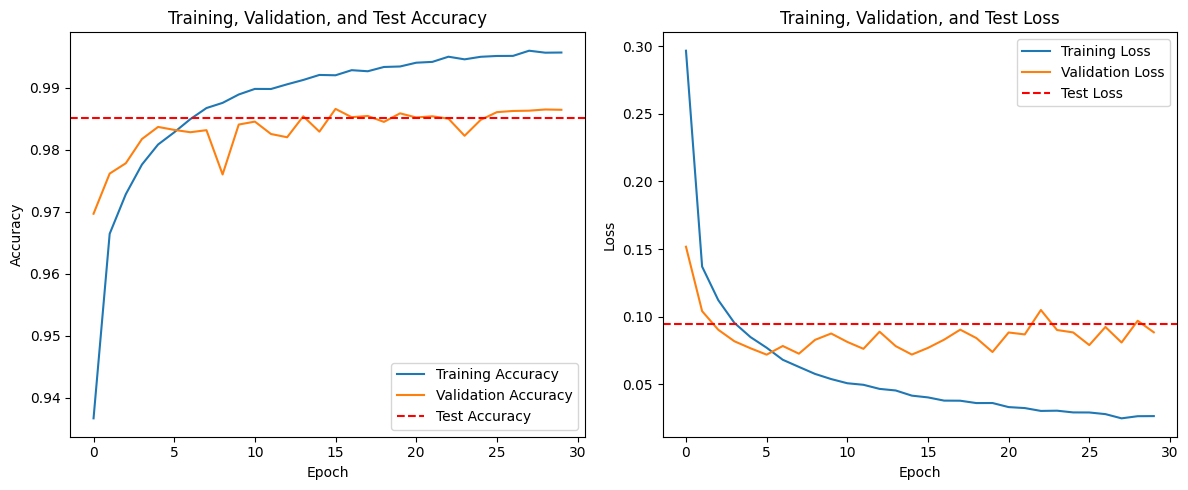

In [166]:
# plotting Training, Validation, and Testing Accuracy & Loss
plt.figure(figsize=(12, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Training, Validation and Test process conclusions:

The training process for the keyword detection using a CNN has shown promising results over `30 epochs`.

- **Accuracy**

  - Training Accuracy: Started at `93.67%` and increased steadily to a high of `99.57%` by the final epoch.

  - Validation Accuracy: Began at `96.97%` and also improved consistently, finishing at `98.65%`. It's accuracy experienced some fluctuations but generally followed an upward trend.

- **Loss**

  -  Training Loss: The model's loss on the training set began at `0.2966` and saw a substantial decrease over time, ending at `0.0265`. This demonstrates the model's increasing ability in classifying the training data.

  -  Validation Loss: The loss on the validation set started at `0.1517` and decreased to 0.0884 by the end of the training. The overall downward trend suggests that the model's predictions are aligning well with the actual labels.

- **Test Results**

  -  Test Loss: The model achieved a test loss of `0.0947`, which is slightly higher than the final validation loss.

  -  Test Accuracy: The test accuracy reached `98.52%`, which is very close to the final validation accuracy, proving the model's ability to generalize unseen data.

The model demonstrates high accuracy and an ability to generalize well, as shown by the test results.

It's important that continued `monitoring` and `fine-tuning` may further enhance its performance in specific real-world scenarios.

### Performace Visualization

This code segment performs an analysis of the classification results of a model on test data. 

It identifies and prints the indices of test samples that were correctly and incorrectly classified by the model. 

It also displays a `confusion matrix`, providing a detailed visual representation of the model's classification performance across different classes.

294/294 [==============================] - 4s 11ms/step
Correctly classified indices: [0, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 217, 218, 221, 222, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 238, 239, 240, 

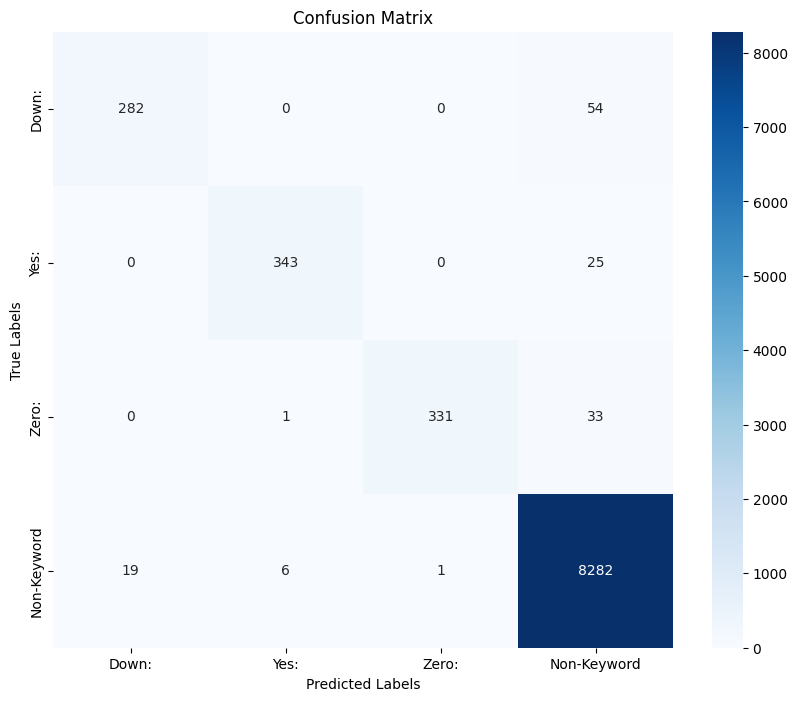

In [167]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# class labels
class_labels = ['Down:', 'Yes:', 'Zero:', 'Non-Keyword']

# creating the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Initialize lists to keep track of successes and failures
correctly_classified_indices = []
incorrectly_classified_indices = []

# Iterate over all the predictions and compare with true labels
for i in range(len(true_classes)):
    if predicted_classes[i] == true_classes[i]:
        correctly_classified_indices.append(i)
    else:
        incorrectly_classified_indices.append(i)

# Display the results
print("Correctly classified indices:", correctly_classified_indices)
print("Incorrectly classified indices:", incorrectly_classified_indices)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix breakdown

- Class **Down**: 

    Out of 336 samples, most were correctly classified with 282 true positives. However, there were 54 instances misclassified as `Non-Keyword`.

- Class **Yes**: 
    
    This class shows high precision with 343 true positives and no misclassifications as other keywords, but 25 samples were mistaken for `Non-Keyword`.

- Class **Zero**: 
    
    This class was mostly correctly identified with 331 true positives. there was 1 instance misclassified as `Yes`, and 33 as `Non-Keyword`.
    
- Class **Non-Keyword**: 

    This class has a significantly higher number of samples, with 8282 correctly classified. Misclassifications include 19 as `Down`, 6 as `Yes`, and 1 as `Zero`.

The above heat map shows the results of me saying the following words one after another: "`Yes`, Bird, Visual, `Down`, Five, `Zero`" 

# Sliding Window App

This code segment imports necessary libraries for processing and analyzing audio data, loads a trained TensorFlow/Keras model, preprocesses audio files to extract features, and applies the model to predict keywords usisng a sliding window filter. 

It prints the detected keywords with their probabilities and visualizes the predictions as a heatmap, showing the model's confidence in predicting each keyword over time.

1/1 [==============================] - 0s 26ms/step
Detected Keyword: Zero Probability: 1.000
Detected Keyword: Zero Probability: 1.000


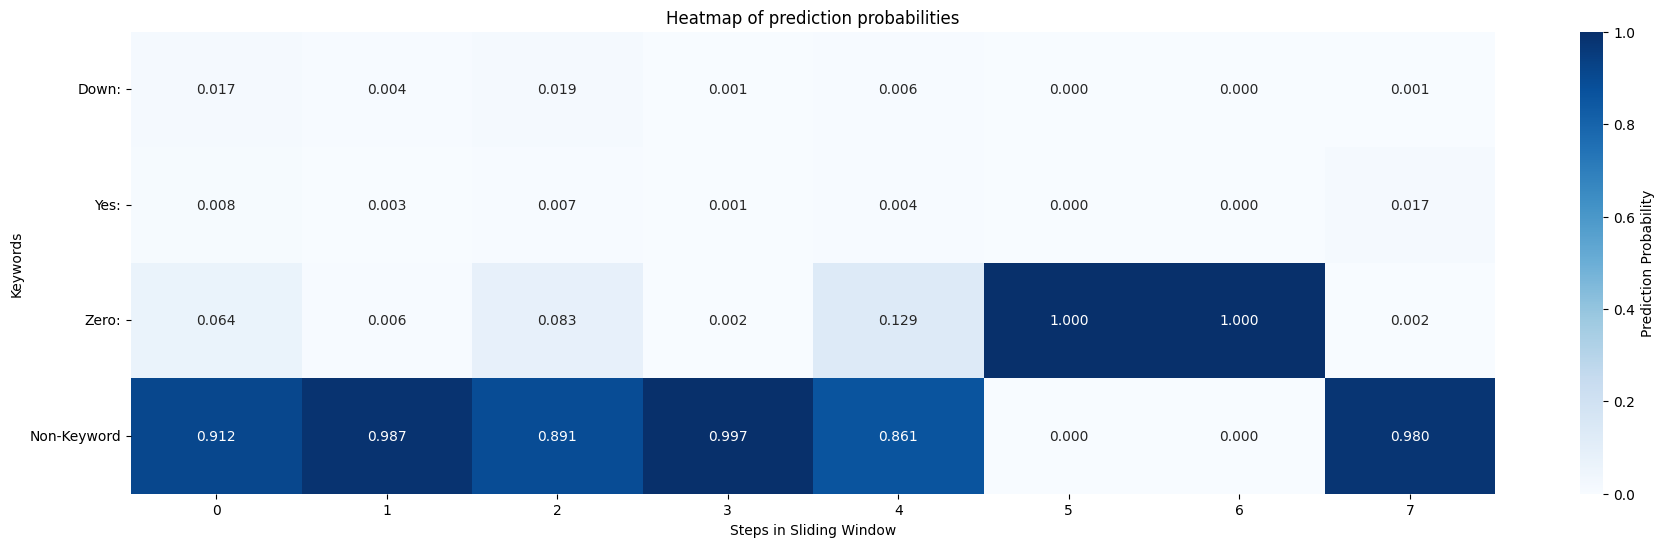

In [5]:
import numpy as np   # providing libraries once again so the model can be tested from this part of notebook without any previous actions
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
from IPython.display import Audio, Image, display

def load_model(model_path):    # loads model from a path
    return tf.keras.models.load_model(model_path)

def preprocess_audio_from_array(audio_array, max_length, num_mfcc=20, n_fft=2048, hop_length=512):     # provided same MFCC values which the model was trained on to sustain compatibility
    # MFCC feature extraction and its deltas
    mfcc = librosa.feature.mfcc(y=audio_array, sr=16000, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    combined_mfcc = np.dstack((mfcc, delta_mfcc, delta2_mfcc))
    return combined_mfcc[np.newaxis, ..., np.newaxis]

step_size=8000     # value adjustment
window_size=16000

def sliding_window_predict(model, audio_path, window_size = window_size, step_size = step_size ): # sliding window function
    audio, sr = librosa.load(audio_path, sr=16000)                                                # sets a consistent sample rate
    num_windows = int(np.ceil((len(audio) - window_size) / step_size)) + 1

    all_predictions = []  # storing predictions for each window

    for i in range(num_windows):
        start = i * step_size
        end = start + window_size
        audio_segment = audio[start:end]

        if len(audio_segment) < window_size:
            padding = window_size - len(audio_segment)
            audio_segment = np.pad(audio_segment, (0, padding), mode='constant')

        processed_audio_segment = preprocess_audio_from_array(audio_segment, window_size)
        predictions = model.predict(processed_audio_segment)
        predicted_probabilities = predictions[0]                 # assuming model outputs probabilities for each class

        all_predictions.append(predicted_probabilities)

    return all_predictions

# loadin model form a provided path
three_layer_CNN = r"C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\model\CategoricalCNN_3layer"
four_layer_CNN = r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\model\CategoricalCNN_4layer'

model_path = four_layer_CNN

model = load_model(model_path)

# path to recordings for testing purposes 
audio_1 = r"C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\audiofiles\audio_1.mp3"
audio_2 = r"C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\audiofiles\audio_2.wav"
audio_3 = r"C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\audiofiles\audio_3.wav"
audio_4 = r"C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\audiofiles\ImagineDragons_zero.wav"

audio_path = audio_4

keywords = ['Down:', 'Yes:', 'Zero:', 'Non-Keyword']

# runs the sliding window prediction
step_predictions = sliding_window_predict(model, audio_path)

# prints out the detected keywords and their probabilities
for i, prediction in enumerate(step_predictions):
    
    predicted_class_index = np.argmax(prediction)       # gets the index of the highest probability

    # checks if the predicted class is not 'non-keyword'
    if predicted_class_index != len(keywords) - 1: 
        predicted_keyword = keywords[predicted_class_index].rstrip(':')     # gets the corresponding keyword label
        probability = prediction[predicted_class_index]                     # gets the probability of the predicted keyword
        print(f"Detected Keyword: {predicted_keyword} Probability: {probability:.3f}")

# initializing the prediction matrix with the probabilities
num_steps = len(step_predictions)
num_classes = len(keywords)
prediction_matrix = np.round(np.array(step_predictions), 3)  # rounding the probabilities so they will fit in each square on heatmap

# plotting the heatmap
plt.figure(figsize=(22, 6))
ax = sns.heatmap(prediction_matrix.T, annot=True, fmt=".3f", cmap="Blues", cbar_kws={'label': 'Prediction Probability'})
ax.set_yticklabels(keywords, rotation= 0)
ax.set_ylabel("Keywords")
ax.set_xlabel("Steps in Sliding Window")
ax.set_title("Heatmap of prediction probabilities")
plt.yticks(rotation=0) 
plt.show()

Audio(audio_path)

## Comparative analysis

Two CNN models were evaluated to see which one performs better. 

The `first model` is simpler with `three layers`, having 16, 32, and 64 filters in each layer, which helps it learn patterns in the data. 

The `second`, more complex model, has `four layers` with more filters in each: 32, 64, 128, and 256. 

This setup is designed to capture even more detailed features. To compare these models, four different audio recordings were used, and the models' ability to accurately recognize content within these recordings was assessed. 

The aim was to determine if having more layers and filters in the four-layer model leads to better recognition of the sounds in the recordings.

### First Recording: 

Audio transcription: "`yes`, bird, visual, `down`, five, `zero`" 

3-layer CNN result:

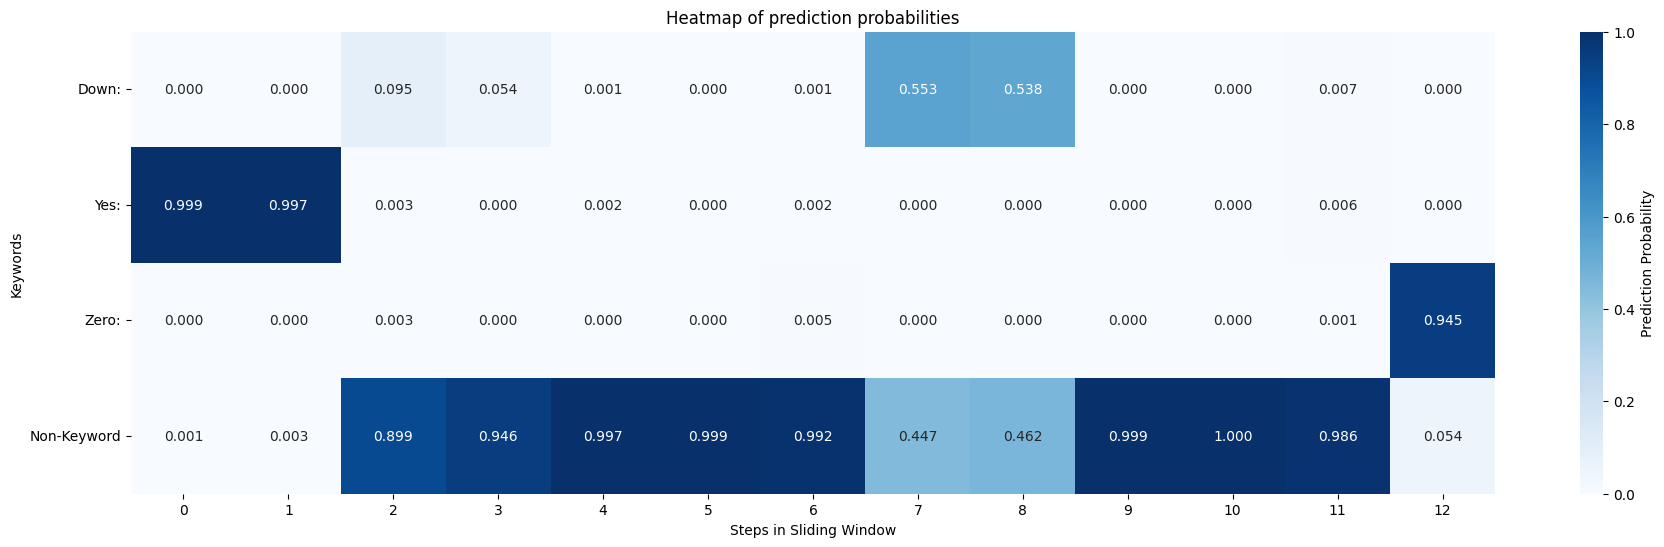

In [ ]:
display(Image(filename=r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\heatmaps\audio_1_3lay.png'))

4-layer CNN result:

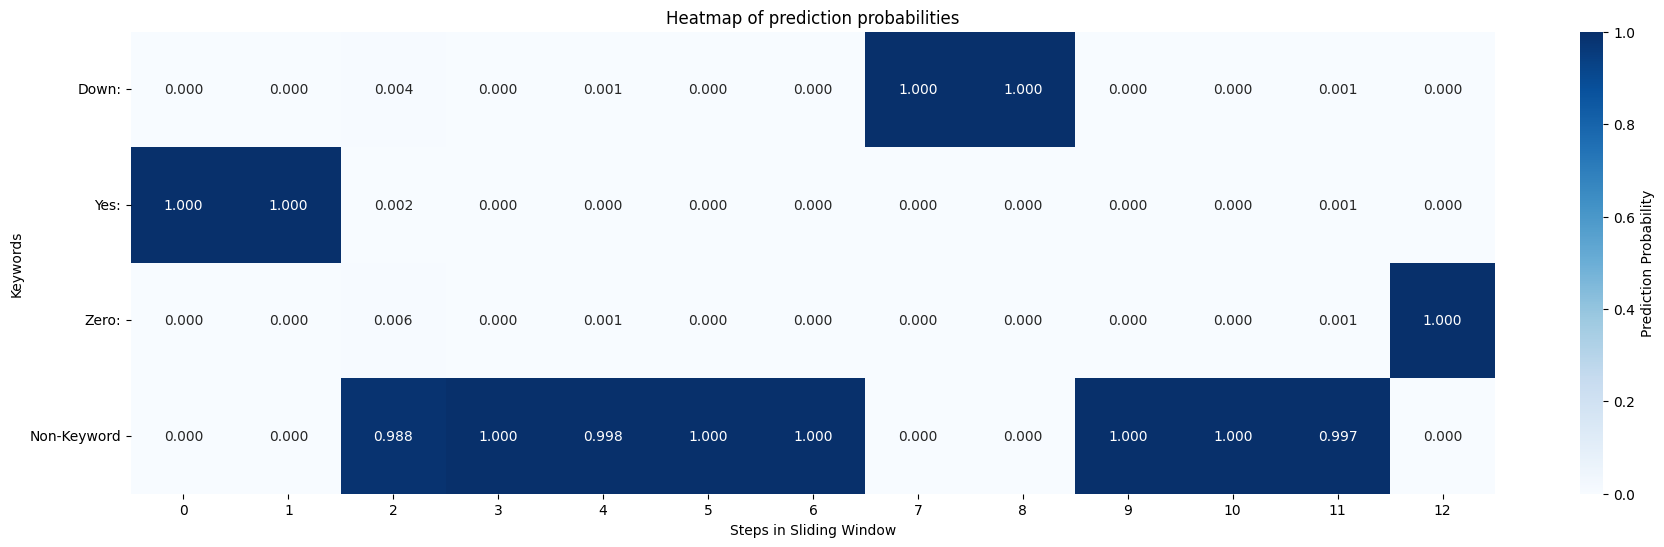

In [ ]:
display(Image(filename=r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\heatmaps\audio_1_4lay.png'))
Audio(audio_1)

### Second Recording: 

Audio transcription: "I just wanna say a bunch of words, for example `zero`, or maby I'm gonna say visual, `down`, or dog"

3-layer CNN results:

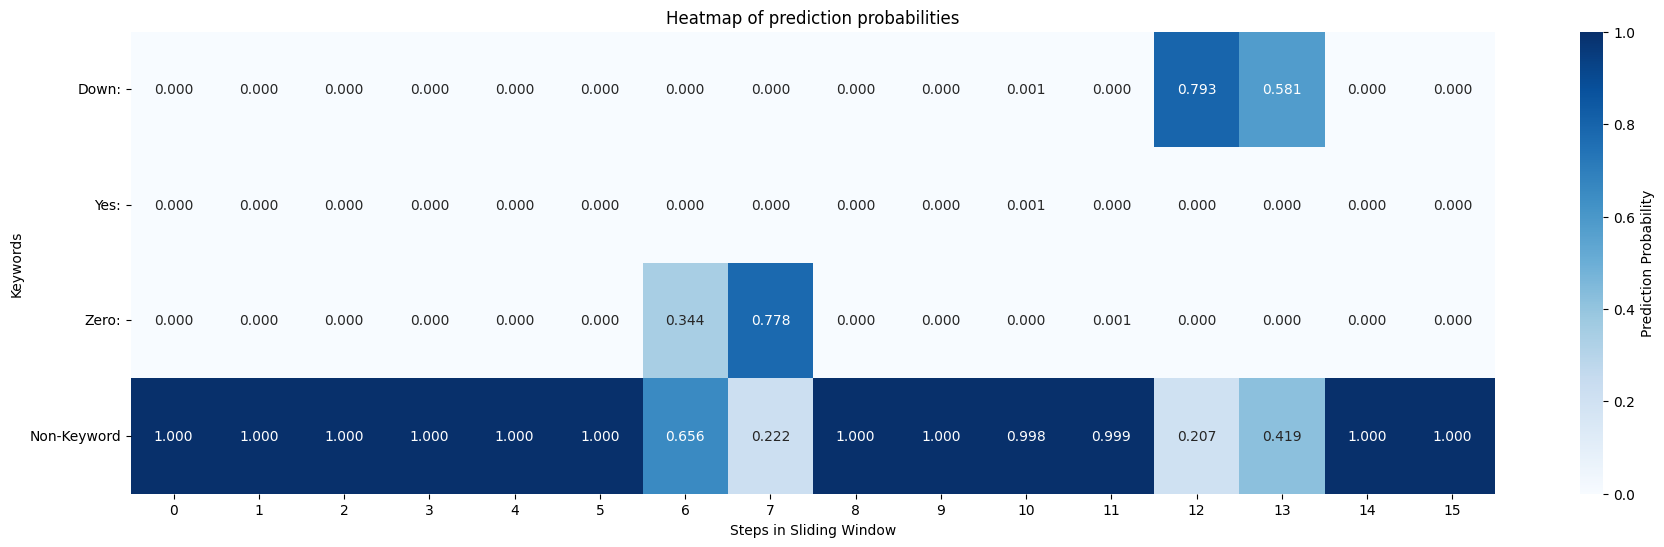

In [ ]:
display(Image(filename=r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\heatmaps\audio_2_3lay.png'))

4-layer CNN result:

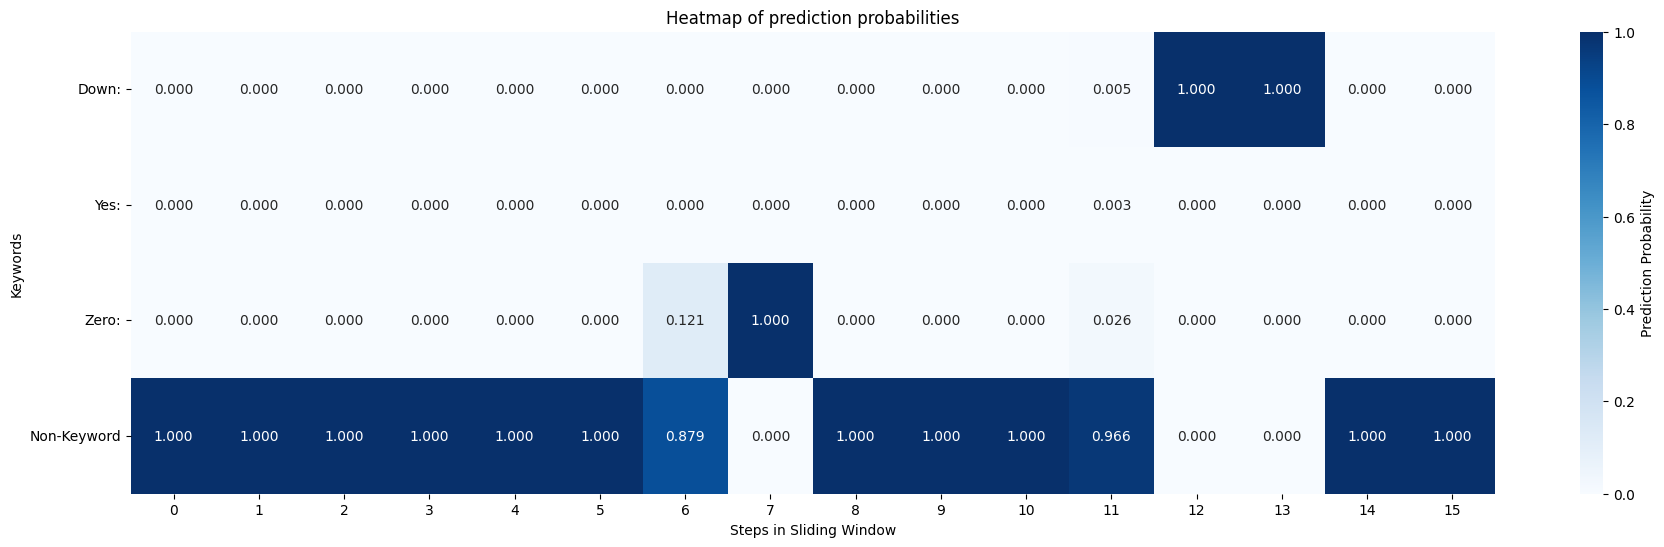

In [ ]:
display(Image(filename=r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\heatmaps\audio_2_4lay.png'))
Audio(audio_2)

### Third Recording: 

Audio transcription: "I have `zero` seconds left for my invitation"

3-layer CNN results:

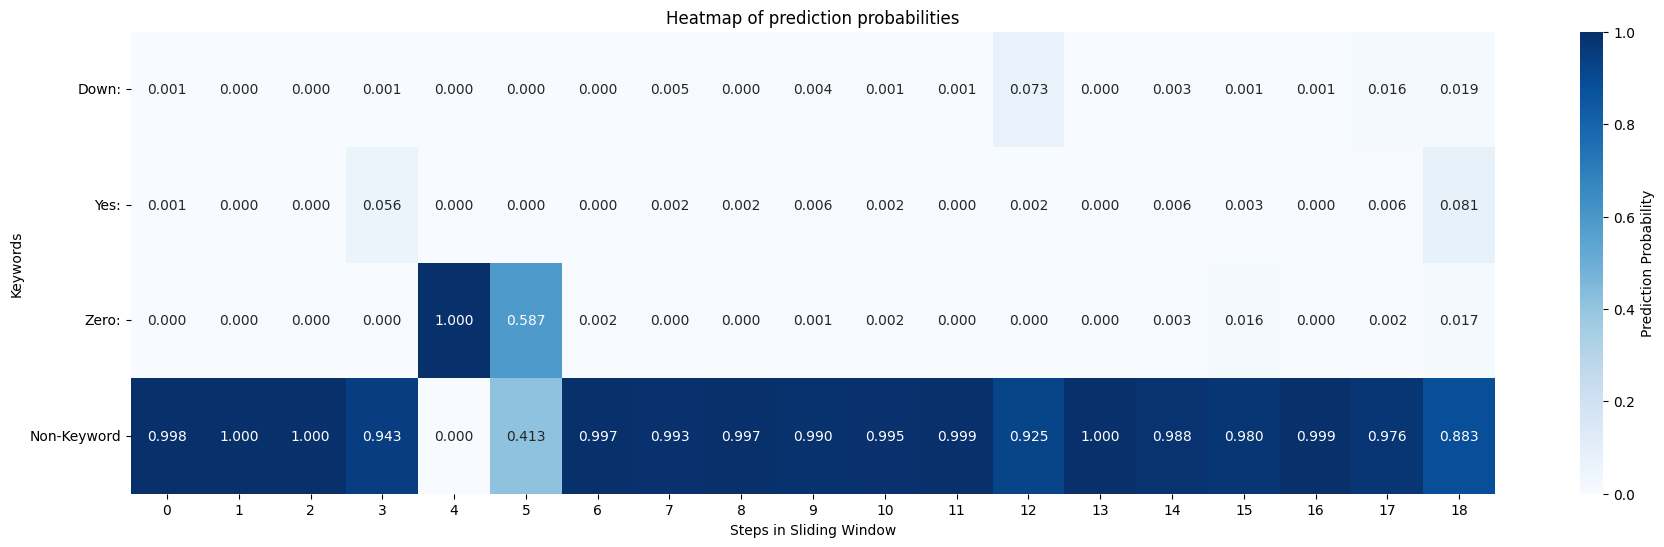

In [ ]:
display(Image(filename=r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\heatmaps\audio_3_3lay.png'))

4-layer CNN results:

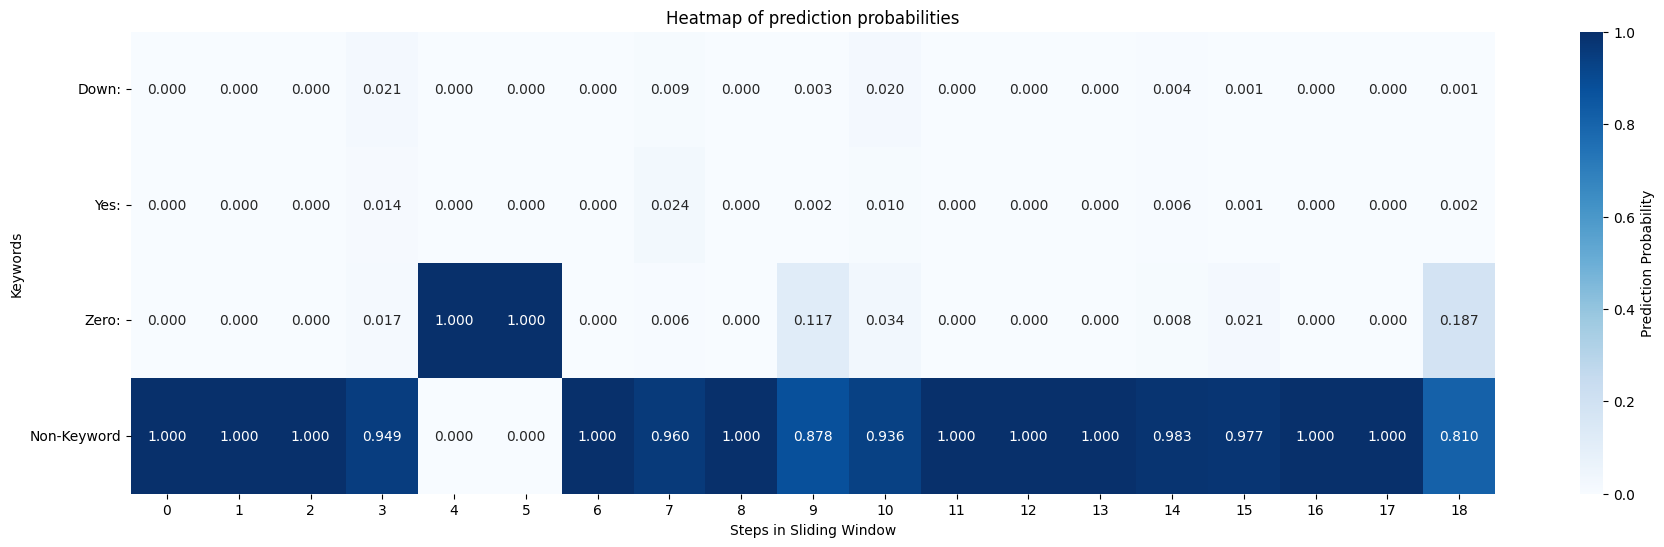

In [ ]:
display(Image(filename=r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\heatmaps\audio_3_4lay.png'))
Audio(audio_3)

### Fourth Recording: 

This is a short sippet of a song called **Zero** by **Imagine Dragons**

Audio transcription: "Hello, hello, Let me tell you what it's like to be a `zero`, `zero`, Let me show you"

3-layer CNN results:

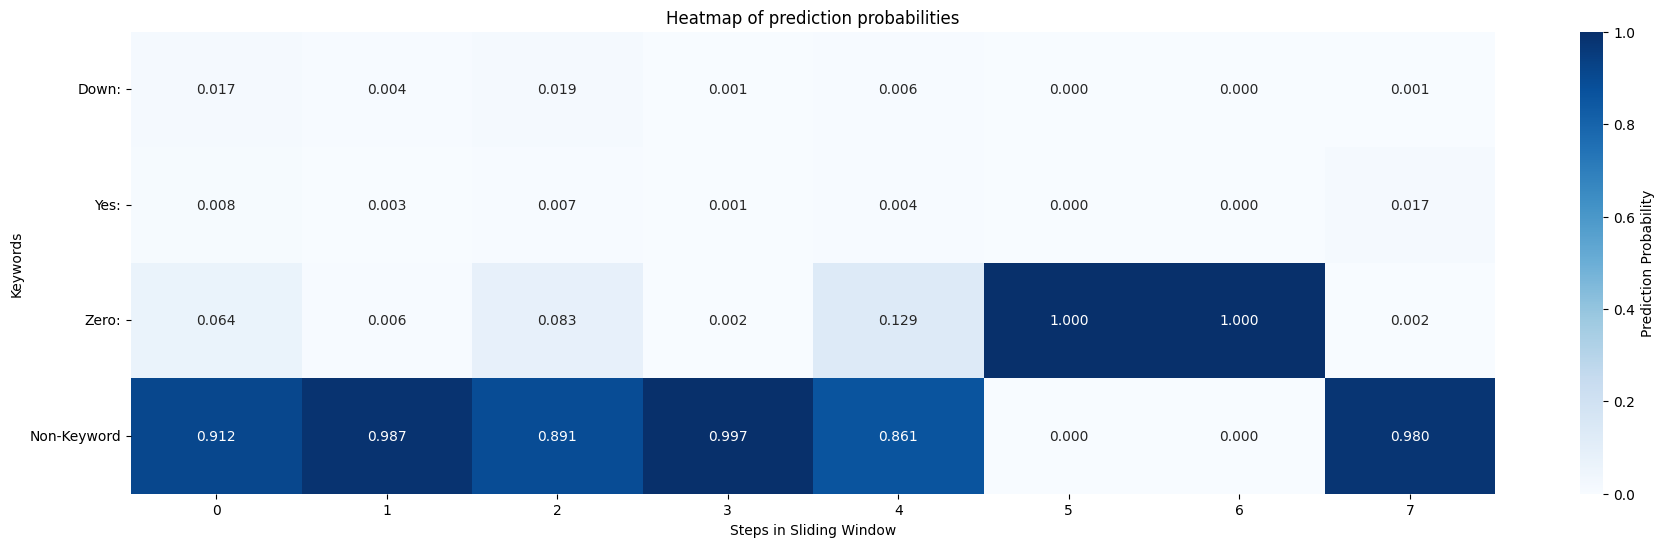

In [ ]:
display(Image(filename=r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\heatmaps\audio_4_4lay.png'))

4-layer CNN results:

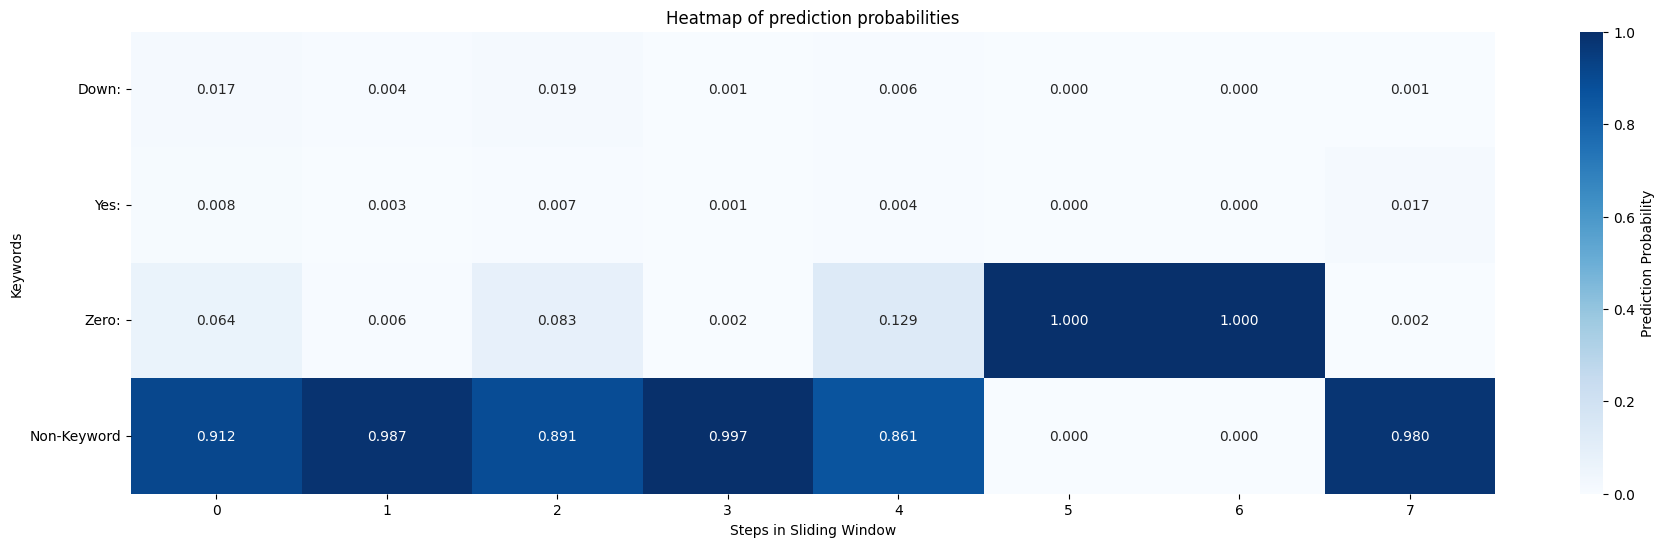

In [ ]:
display(Image(filename=r'C:\Users\kamil\OneDrive\Pulpit\EASAR_all_files\heatmaps\audio_4_4lay.png'))
Audio(audio_4)

### Final conclusions

After evaluating the performance of both the 3-layer and 4-layer Convolutional Neural Network (CNN) models through the analysis of heatmaps showcasing prediction probabilities, a clear conclusion can be drawn. 

The `4-layer model`, with its additional convolutional layer and a higher number of filters, demonstrates `superior performance` in the `keyword detection task.` 

Its ability to capture more complex features within the audio recordings results in more accurate and confident keyword predictions, as evidenced by the darker shades on the heatmap indicating higher probabilities.

While the `3-layer model` performance `is satisfactory`, the increased depth of the `4-layer model` provides a `significant advantage`, leading to a more reliable classification. 

Therefore, for applications where precise keyword detection is paramount, a more complex architecture like the 4-layer CNN may yield better outcomes.

However, it's important to note that `more layers` **don't** automatically guarantee `better performance`, because the effectiveness also heavily depends on `data augmentation`, `proper tuning`, and `optimization` of the model's parameters.
